In [1]:
import glob
import os
import sys
import pdb
import os.path as osp
sys.path.append(os.getcwd())

import torch
import pickle as pk
import cv2
import numpy as np
import argparse
import matplotlib.pyplot as plt


from zen_renderer.dataloaders.dataset_amass import Dataset_AMASS
from zen_renderer.smpl_parser import SMPL_Parser
from zen_renderer.renderer.smpl_renderer import SMPL_Renderer
from zen_renderer.utils.transform_utils import *

from scipy.spatial.transform import Rotation as sciR

import neural_renderer as nr

dtype = torch.FloatTensor
device = torch.device('cuda', index=0) if torch.cuda.is_available() else torch.device('cpu')
smpl_renderer = SMPL_Renderer(device = device, image_size = 512)



[-9.00000002e+01 -2.20236644e-07 -9.00000002e+01]
[-1.36024059e-16  2.22144147e+00  2.22144147e+00]


/root/anaconda3/envs/actmix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


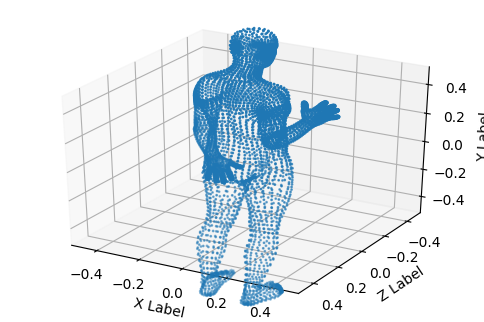

In [2]:
def display_smpl(pose, idx = 0):
    pose = torch.tensor(pose).to(device)
    verts, Jtr = smpl_p.get_vert_from_pose(pose)
    verts_np = verts.cpu().detach().numpy()
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure(dpi  = 100)
    ax = fig.add_subplot(111, projection='3d')
#     ax.view_init(elev=0., azim=-90)
    ax.scatter(verts_np[idx][:,0], -verts_np[idx][:,1], verts_np[idx][:,2], s = 1)


    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0.5, -0.5)
    ax.set_zlim(-0.5, 0.5)

    plt.show()

def display_root(pose, root):
    pose = torch.tensor(pose).to(device).type(dtype)
    pose[:, :3] = torch.tensor(root, device = device).repeat(pose.shape[0], 1)
    display_smpl(pose)
    
def display_root_ntu(root):
    import joblib
    ntu_data_path = "/hdd/zen/data/VIBE/VIBE_NTU/A029/S013C001P027R001A029_rgb.pkl"
    ntu_data = joblib.load(open(ntu_data_path, "rb"))
    key = list(ntu_data.keys())[0]
    pose = ntu_data[key]['pose']
    display_root(pose, root)
from scipy.spatial.transform import Rotation as R
r = R.from_rotvec(np.array([1.20919958, -1.20919958, -1.20919958]))
print(r.as_euler('zxy', degrees=True))
r = R.from_euler('zxy', [180, -90, 0], degrees = True)

smpl_p = SMPL_Parser(device = device)

vet_rot = r.as_rotvec()
print(vet_rot)
display_root_ntu(vet_rot)

### SMPL Inspection

[0. 0. 0.]


/root/anaconda3/envs/actmix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


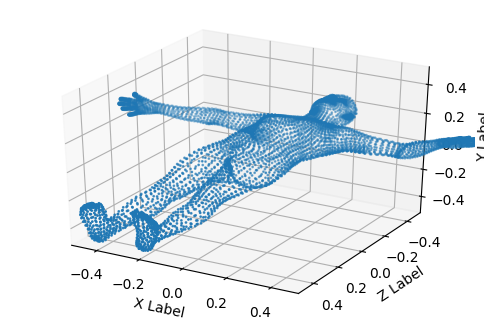

In [3]:


# r = R.from_euler('zxy', [-90, 90, -90], degrees = True)
r = R.from_euler('zxy', [0, 0, 0], degrees = True)
vet_rot = r.as_rotvec()
print(vet_rot)
    
pose = np.zeros((1, 72))

pose = pose.reshape(24, 3)
pose[18] = 1

pose = pose.reshape(1, 72)
display_root(pose, vet_rot)

In [4]:
import joblib
from smplx import SMPL as _SMPL
ntu_data_path = "/hdd/zen/data/VIBE/VIBE_NTU/A029/S013C001P027R001A029_rgb.pkl"
ntu_data = joblib.load(open(ntu_data_path, "rb"))


In [5]:
ntu_data[641]['joints3d'].shape

(106, 49, 3)

In [6]:
ntu_data[641]['pose'].shape

(106, 72)

###  Data inspection

In [1]:
import glob
import os
import sys
import pdb
import os.path as osp
sys.path.append(os.getcwd())

import torch
import pickle as pk
import cv2
import numpy as np
import argparse
import matplotlib.pyplot as plt

from zen_renderer.smpl_parser import SMPL_Parser
from zen_renderer.dataloaders.dataset_amass import Dataset_AMASS
from zen_renderer.renderer.smpl_renderer import SMPL_Renderer
from zen_renderer.utils.transform_utils import *

from scipy.spatial.transform import Rotation as sciR

import neural_renderer as nr

rf_data = pk.load(open("/hdd/zen/data/ActBound/AMASS/real_fake_train_take2.pkl", "rb"))
fig = plt.figure(dpi = 100)
device = (
        torch.device("cuda", index=0)
        if torch.cuda.is_available()
        else torch.device("cpu")
    )

<Figure size 600x400 with 0 Axes>

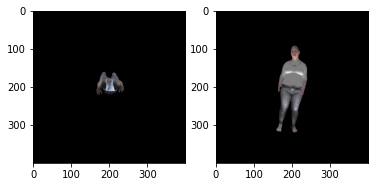

here


In [13]:
import importlib
import zen_renderer.renderer.smpl_renderer as smpl_renderer  
importlib.reload(smpl_renderer)


smpl_renderer = smpl_renderer.SMPL_Renderer(device = device, image_size = 400, camera_mode = "look_at")
for idx, (k, v) in enumerate(rf_data.items()):
    if idx > 0 and len(v['flip_pose'] )> 0:
        curr_pose_6d = v['pose'][:1, :]
        curr_pose = convert_orth_6d_to_aa(torch.tensor(curr_pose_6d).float())
        curr_images, masks = smpl_renderer.render_pose_img(curr_pose, frame_chunk = 1)
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(curr_images[0], cv2.COLOR_BGR2RGB))

        flip_pose = v['flip_pose'][0][:1, :]
        flip_pose = convert_orth_6d_to_aa(torch.tensor(flip_pose).float())
        flip_pose = flip_pose.reshape(-1, 3)

        flip_pose = flip_pose.reshape(1, 72)
        images, masks = smpl_renderer.render_pose_img(flip_pose, frame_chunk = 1)
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        plt.show()
        print("here")
        break



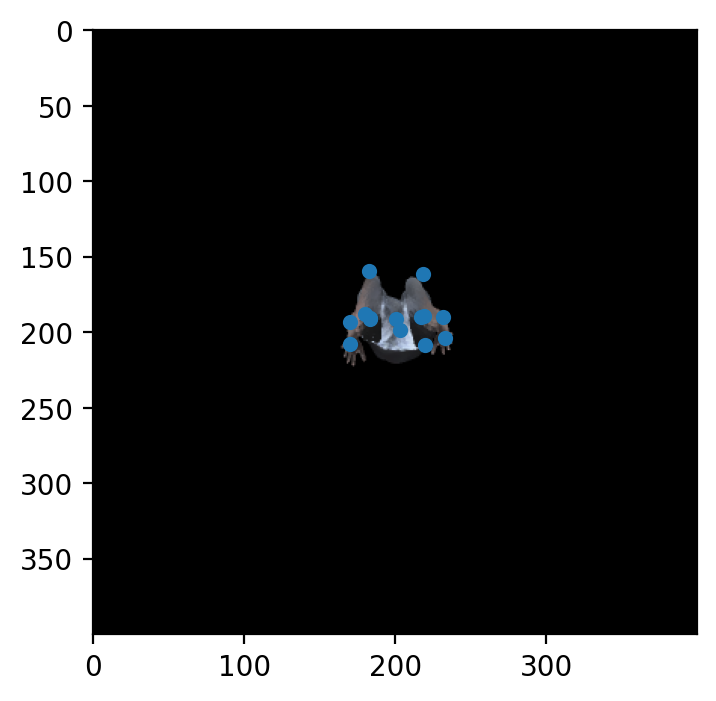

In [18]:

import importlib
import zen_renderer.renderer.smpl_renderer as smpl_renderer  
import zen_renderer.smpl_parser as smpl_parser
importlib.reload(smpl_renderer)
importlib.reload(smpl_parser)

H36M_TO_J14 = smpl_parser.H36M_TO_J14
device = (
        torch.device("cuda", index=0)
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
# device = torch.device("cpu")
smpl_p = smpl_parser.SMPL_Parser(device = device)
fig = plt.figure(dpi  = 200)
smpl_renderer = smpl_renderer.SMPL_Renderer(device = device, image_size = 400, camera_mode = "look_at")

# curr_pose = torch.tensor(np.zeros((1, 72))).float().to(device)
# pk.dump(np.repeat(curr_pose[None, :], 90, axis = 1), open("/hdd/zen/data/ActBound/Language/netural_pose.pkl", "wb"))
# fig = plt.figure(dpi  = 200)

# verts, Jtr = smpl_p.get_vert_from_pose(curr_pose.to(device))
# verts, Jtr = smpl_p.get_all_from_pose(curr_pose.to(device))
# print(Jtr.shape)
# verts = verts
# print(verts)
verts_perp, joints_prep, verts_3d, joints_3d, joints_36m = smpl_renderer.look_at_verts(curr_pose.to(device))
# verts_disp = verts_disp.cpu().numpy()[0]

# verts_lookat = nr.look_at(verts, smpl_renderer.renderer.eye)
# verts_perp = nr.perspective(verts_lookat)
# verts_perp *= 1024/5
# verts_perp += 200

# joints_lookat = nr.look_at(Jtr, smpl_renderer.renderer.eye)
# joints_prep = nr.perspective(joints_lookat)
# joints_prep *= 1024/5
# joints_prep += 200


verts_disp = verts_perp.cpu().numpy()[0]
jts_disp = joints_prep.cpu().numpy()[0]

# plt.scatter(verts_disp[:,0], verts_disp[:,1], s = 0.1)
plt.scatter(jts_disp[H36M_TO_J14,0], jts_disp[H36M_TO_J14,1], s = 20)
plt.imshow(cv2.cvtColor(curr_images[0], cv2.COLOR_BGR2RGB))

In [20]:
verts_3d.shape[-2:]

torch.Size([6890, 3])

In [50]:
# import kinematic_synthesis.lib.smpl as kin_smpl
# importlib.reload(kin_smpl)
# smpl = kin_smpl.SMPL(kin_smpl.SMPL_MODEL_DIR, batch_size=1, create_transl=False)
# smpl.to(device)
# smpl_out = smpl(body_pose=curr_pose[:,3:], global_orient=curr_pose[:,:3])

In [57]:
jts_disp.shape

(49, 3)

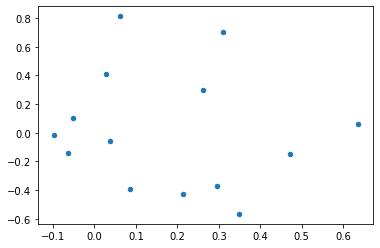

In [64]:
J_regressor = smpl_p.J_regressor
J_regressor_batch = J_regressor[None, :].expand(verts_3d.shape[0], -1, -1).to(verts_3d.device)
j3d = torch.matmul(J_regressor_batch, verts_3d)
j3d = j3d[:, H36M_TO_J14, :].cpu().numpy()
plt.scatter(j3d[:,:,0], j3d[:,:,1], s = 20)

In [5]:
pose = torch.tensor(pose).to(device).type(dtype)
pose[:, :3] = torch.tensor(vet_rot, device = device).repeat(pose.shape[0], 1)
verts, Jtr = smpl_p.get_vert_from_pose(pose)
dist_coeffs = torch.cuda.FloatTensor([[0., 0., 0., 0., 0.]])
# verts_np = verts.cpu().detach().numpy()

In [6]:
rf_data = pk.load(open("/hdd/zen/data/ActBound/AMASS/amass_take3.pkl", "rb"))

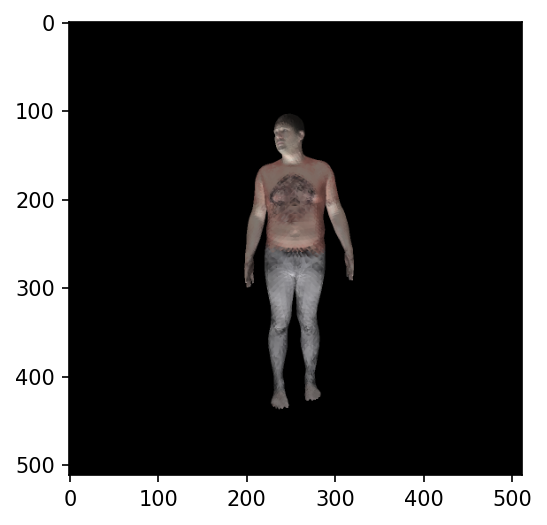

In [40]:
import importlib
import zen_renderer.renderer.smpl_renderer as smpl_renderer
importlib.reload(smpl_renderer)


fx = 500.0
fy = 500.0
cx = 512.0
cy = 512.0
def_K = np.array( [ [fx, 0., cx],
                [ 0. ,fx, cy],
                [0.,0.,1.]])


# rot = np.random.randint(0, 360)
# pitch = np.random.randint(180, 270)
# print(pitch, rot)
# r = sciR.from_euler('zxy', [rot, pitch, 0], degrees = True)
# r2 = sciR.from_euler('zxy', [0, 0, rot], degrees = True)
# r = sciR.from_euler('zxy', [0, 220, 0], degrees = True)
# root_vec = (r2 * r).as_rotvec()

def sample_random_hemisphere_root():
    rot = np.random.random() * np.pi * 2
    pitch =  np.random.random() * np.pi/3 + np.pi
    r = sciR.from_rotvec([pitch, 0, 0])
    r2 = sciR.from_rotvec([0, rot, 0])
    root_vec = (r * r2).as_rotvec()
    return root_vec


r = R.from_euler('zxy', [180, 90, 0], degrees = True)
vet_rot = r.as_matrix()
# print(vet_rot)


def_K = def_K[None, :]
def_R = vet_rot[None, :]
def_t = np.array([0, 0, 1.5])

s_renderer = smpl_renderer.SMPL_Renderer(camera_mode = "look_at", device = device, image_size = 512)
s_renderer.set_render_angles(2.5, 0, 0)

fig = plt.figure(dpi = 150)
for idx, (k, v) in enumerate(rf_data.items()):
    curr_pose = v['pose'][1:2, :]
    curr_pose = convert_orth_6d_to_aa(torch.tensor(curr_pose).float())
#     curr_pose = vertizalize_smpl_root(curr_pose)
#     curr_pose = torch.zeros(curr_pose.shape).double()
#     curr_pose = curr_pose.reshape(24, 3)
#     curr_pose[18] = 1
#     curr_pose = curr_pose.reshape(1, 72)
#     curr_pose = vertizalize_smpl_root(curr_pose, sample_random_hemisphere_root())
#     root_vec, pitch = smpl_renderer.set_random_eye_level()
#     curr_pose = hmmr_pose[0:3]
    

    
    shape_params = torch.rand(1, 10).repeat(curr_pose.shape[0], 1)
    s_id = torch.tensor(np.random.normal(scale = 1.5, size = (3)))
    shape_params[:,:3] = s_id
    
    th_betas=torch.zeros(1)
    images, masks = s_renderer.render_pose_img(curr_pose, frame_chunk = 1, random_camera = 2)
    for i in range(len(images)):
#         plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.show()
    break

In [ ]:
# r = sciR.from_euler('zxy', [0, 180, 0], degrees = True)

rot = np.random.random() * np.pi * 2
pitch = np.random.random() * np.pi + np.pi /2
print(pitch, rot)
r = sciR.from_rotvec([pitch, 0, 0])
r2 = sciR.from_rotvec([0, rot, 0])
root_vec = (r * r2).as_rotvec()

pose = np.zeros((1, 72))

pose = pose.reshape(24, 3)
pose[18] = 1

pose = pose.reshape(1, 72)
display_root(pose, root_vec)

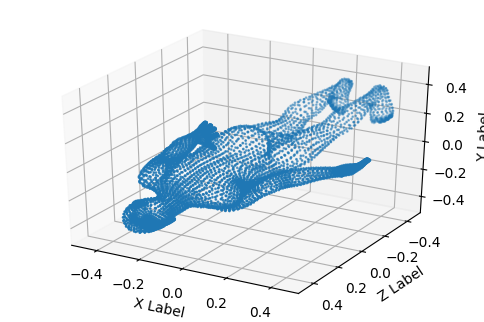

In [9]:
import joblib
vibe_data = joblib.load("/hdd/zen/data/VIBE/VIBE_AMASS/take2/000000.pkl")
vibe_pose = list(vibe_data.items())[0][1]["pose"]
display_smpl(vibe_pose)

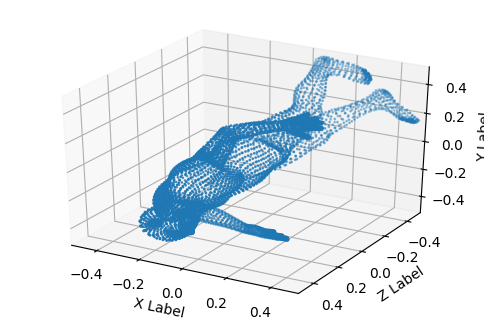

In [10]:
hmmr_data = pk.load(open("/hdd/zen/data/HMMR/results/amass/take2/000000.mp4/hmmr_output/hmmr_output.pkl", "rb"))
hmmr_pose = hmmr_data['poses']
hmmr_pose = smpl_mat_to_aa(hmmr_pose).reshape(-1, 72)
display_smpl(hmmr_pose, idx = 120)

### Transpose

In [1]:
import glob
import os
import sys
import pdb
import os.path as osp
sys.path.append(os.getcwd())
import pickle as pk

amass_base = "/hdd/zen/data/ActBound/AMASS/"
data_lag = pk.load(open(os.path.join(amass_base, "amass_language_trans.pkl"), "rb"))

In [2]:
import zen_renderer.renderer.smpl_renderer as smpl_renderer
import importlib
import torch

importlib.reload(smpl_renderer)

device = (
        torch.device("cuda", index=0)
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
image_size = 400
render = smpl_renderer.SMPL_Renderer(device = device, image_size = image_size, camera_mode="look_at")

for idx, (k, v) in enumerate(data_lag.items()):
    print(k)
    if idx == 12:
        curr_pose = v['pose'][:30, 3:]
        curr_root = v['pose'][:30, :3]
        curr_pose = torch.tensor(curr_pose).to(device)
        curr_root = torch.tensor(curr_root).to(device).float()

        curr_root = torch.index_select(curr_root, 1, torch.LongTensor([2,1,0]).to(device))
        curr_root[:,2] *= -1
        render.render_pose_vid(curr_pose, random_camera = 2, th_trans = curr_root)
        break

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012


/hdd/zen/dev/ActMix/actmix/DataGen/MotionRender/ActmixTorchGenerator/zen_renderer/renderer/smpl_renderer.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poses = convert_orth_6d_to_aa(torch.tensor(poses, dtype = self.dtype)).to(self.device)
